In [1]:
from matplotlib import font_manager
from matplotlib import rc

f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()

rc('font', family='Arial Unicode MS')

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from networkx.algorithms import bipartite, community
from networkx.algorithms.community import modularity, louvain_communities
import matplotlib.colors as mcolors
from collections import Counter
import pandas as pd


In [3]:
# 파일 읽기
file_path = '../local_data/annotated_dataset.csv'
df = pd.read_csv(file_path)

# 데이터프레임에서 필요한 열만 추출
df['keywords'] = df['keywords'].apply(lambda x: x.strip("[]").split(", "))
df['keywords'] = df['keywords'].apply(lambda x: [k.strip("'") for k in x])


# # 데이터 확인
# print(df.head())


In [4]:
colors = list(mcolors.TABLEAU_COLORS.values())

# 다이나믹스 분석


In [5]:
def create_graph(group):
    B = nx.Graph()
    categories = group['category'].unique()
    keywords = sum(group['keywords'].tolist(), [])
    B.add_nodes_from(categories, bipartite=0)
    B.add_nodes_from(keywords, bipartite=1)
    for _, row in group.iterrows():
        category = row['category']
        for keyword in row['keywords']:
            B.add_edge(category, keyword)
    return B

def calculate_authorities(B):
    hubs, authorities = nx.hits(B)
    sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)
    return authorities, sorted_authorities

def create_projected_graph(category_nodes, B, n):
    projected_graph = nx.Graph()
    projected_graph.add_nodes_from(category_nodes)
    for category in category_nodes:
        lengths = nx.single_source_shortest_path_length(B, category, cutoff=n)
        for target, length in lengths.items():
            if target in category_nodes and category != target:
                if projected_graph.has_edge(category, target):
                    projected_graph[category][target]['weight'] += 1
                else:
                    projected_graph.add_edge(category, target, weight=1)
    return projected_graph

def detect_communities(projected_graph):
    louvain_communities_ = louvain_communities(projected_graph)
    return louvain_communities_

def calculate_community_scores(B, louvain_communities, projected_graph, authorities, keywords):
    community_scores = []
    for i, comm in enumerate(louvain_communities):
        comm_nodes = list(comm)
        subgraph = projected_graph.subgraph(comm_nodes)
        size = len(comm_nodes)
        density = nx.density(subgraph)
        connected_keywords = set()
        for category in comm_nodes:
            connected_keywords.update(B.neighbors(category))
        keyword_count = len(connected_keywords)
        keyword_ratio = keyword_count / len(keywords)
        community_scores.append({
            'Community': i + 1,
            'Size': size,
            'Density': density,
            'Keyword Count': keyword_count,
            'Keyword Ratio': keyword_ratio,
            'Nodes': tuple(sorted(comm_nodes))
        })
    return community_scores

def analyze_community_dynamics(previous_communities, current_communities, authorities, trial_index):
    new_communities = set(current_communities.keys()) - set(previous_communities.keys())
    disappearing_communities = set(previous_communities.keys()) - set(current_communities.keys())
    persisting_communities = set(previous_communities.keys()) & set(current_communities.keys())
    shrinking_communities = set()
    expanding_communities = set()
    # print(f"\nCommunity Dynamics for Trial Index {trial_index}:")
    # print(f"New Communities: {len(new_communities)}: {new_communities}")
    # print(f"Disappearing Communities: {len(disappearing_communities)}: {disappearing_communities}")
    # print(f"Persisting Communities: {len(persisting_communities)}: {persisting_communities}")
    for comm_nodes in persisting_communities:
        prev_comm = previous_communities[comm_nodes]
        curr_comm = current_communities[comm_nodes]
        change_in_keyword_count = curr_comm['Keyword Count'] - prev_comm['Keyword Count']
        # print(f"Community {curr_comm['Community']} persists with keyword count change: {change_in_keyword_count}")
        if change_in_keyword_count > 0:
            expanding_communities.add(comm_nodes)
        elif change_in_keyword_count < 0:
            shrinking_communities.add(comm_nodes)
    return new_communities, disappearing_communities, persisting_communities, shrinking_communities, expanding_communities

def visualize_community_counts(community_counts, tester):
    trial_indices, counts = zip(*community_counts)
    plt.figure(figsize=(6, 3))
    plt.plot(trial_indices, counts, marker='o')
    plt.xlabel('Trial Index')
    plt.ylabel('Number of Communities')
    plt.title(f'Number of Communities Over Time: {tester}')
    plt.show()

def visualize_community_sizes(community_sizes, tester):
    plt.figure(figsize=(6, 3))
    for trial_index, sizes in community_sizes:
        plt.scatter([trial_index] * len(sizes), sizes)
    plt.xlabel('Trial Index')
    plt.ylabel('Community Size (Keyword Count)')
    plt.title(f'Community Size (Keyword Count) Over Time: {tester}')
    plt.show()

def visualize_community_persistence(community_persistence, tester):
    persisting_counts = [entry['persisting'] for entry in community_persistence]
    new_counts = [entry['new'] for entry in community_persistence]
    disappearing_counts = [entry['disappearing'] for entry in community_persistence]
    shrinking_counts = [entry['shrinking'] for entry in community_persistence]
    expanding_counts = [entry['expanding'] for entry in community_persistence]
    persisting_trial_indices = [entry['trial_idx'] for entry in community_persistence]
    plt.figure(figsize=(6, 3))
    plt.plot(persisting_trial_indices, persisting_counts, marker='o', label='Persisting')
    plt.plot(persisting_trial_indices, new_counts, marker='o', label='New')
    plt.plot(persisting_trial_indices, disappearing_counts, marker='o', label='Disappearing')
    plt.plot(persisting_trial_indices, shrinking_counts, marker='o', label='Shrinking')
    plt.plot(persisting_trial_indices, expanding_counts, marker='o', label='Expanding')
    plt.xlabel('Trial Index')
    plt.ylabel('Number of Communities')
    plt.title(f'Community Persistence Over Time: {tester}')
    plt.legend()
    plt.show()

def visualize_community_movement(community_movement, tester):
    movement_df = pd.DataFrame(community_movement)
    if not movement_df.empty:
        movement_df['color'] = movement_df['community'].apply(lambda x: colors[x % len(colors)])
        plt.figure(figsize=(6, 3))
        for community, group in movement_df.groupby('community'):
            plt.plot(group['trial_idx'], group['prev_center'], marker='o', linestyle='-', label=f'Community {community} Prev', color=group['color'].iloc[0])
            plt.plot(group['trial_idx'], group['curr_center'], marker='x', linestyle='--', label=f'Community {community} Curr', color=group['color'].iloc[0])
        plt.xlabel('Trial Index')
        plt.ylabel('Center Node')
        plt.title(f'Community Center Movement Over Time: {tester}')
        plt.legend()
        plt.show()

def print_category_stats(counter, title, max_len=5):
    sorted_categories = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    print(f"\n{title}:")
    for i, (categories, count) in enumerate(sorted_categories):
        print(f"{categories}: {count}")
        if max_len > 0 and i == max_len - 1:
            break



In [6]:
def analyze_loop(df, tester):
    filtered_df = df[df['tester'] == tester]
    grouped = filtered_df.groupby('trial_idx')
    graphs = []
    community_dynamics = []
    n = 8
    previous_communities = {}
    community_counts = []
    community_sizes = []
    community_persistence = []
    community_movement = []
    persisting_communities_counter = Counter()
    disappearing_communities_counter = Counter()
    new_communities_counter = Counter()
    shrinking_communities_counter = Counter()
    expanding_communities_counter = Counter()

    for trial_index, group in grouped:
        B = create_graph(group)
        graphs.append((trial_index, B))
        authorities, sorted_authorities = calculate_authorities(B)
        category_nodes = set(group['category'].unique())
        projected_graph = create_projected_graph(category_nodes, B, n)
        louvain_communities_ = detect_communities(projected_graph)
        community_scores = calculate_community_scores(B, louvain_communities_, projected_graph, authorities, sum(group['keywords'].tolist(), []))
        current_communities = {comm['Nodes']: comm for comm in community_scores}
        if previous_communities:
            new_communities, disappearing_communities, persisting_communities, shrinking_communities, expanding_communities = analyze_community_dynamics(previous_communities, current_communities, authorities, trial_index)
            community_persistence.append({
                'trial_idx': trial_index,
                'new': len(new_communities),
                'disappearing': len(disappearing_communities),
                'persisting': len(persisting_communities),
                'shrinking': len(shrinking_communities),
                'expanding': len(expanding_communities)
            })
            persisting_communities_counter.update(persisting_communities)
            new_communities_counter.update(new_communities)
            disappearing_communities_counter.update(disappearing_communities)
            shrinking_communities_counter.update(shrinking_communities)
            expanding_communities_counter.update(expanding_communities)
            for comm_nodes in persisting_communities:
                prev_comm = previous_communities[comm_nodes]
                curr_comm = current_communities[comm_nodes]
                prev_center = max(prev_comm['Nodes'], key=lambda node: authorities[node])
                curr_center = max(curr_comm['Nodes'], key=lambda node: authorities[node])
                community_movement.append({
                    'trial_idx': trial_index,
                    'community': curr_comm['Community'],
                    'prev_center': prev_center,
                    'curr_center': curr_center
                })
        previous_communities = current_communities
        sorted_communities = sorted(community_scores, key=lambda x: (x['Keyword Count'], x['Density']), reverse=True)
        for comm in sorted_communities:
            # print(f"Community {comm['Community']}: Size={comm['Size']}, Density={comm['Density']:.4f}, Keyword Count={comm['Keyword Count']}, Keyword Ratio={comm['Keyword Ratio']:.4f}")
            # print(f"Nodes: {', '.join(comm['Nodes'])}")
            comm_authorities = [(node, authorities[node]) for node in comm['Nodes']]
            comm_authorities_sorted = sorted(comm_authorities, key=lambda x: x[1], reverse=True)
            # for rank, (node, score) in enumerate(comm_authorities_sorted, start=1):
            #     print(f"  {node}: Authority={score:.4f}, Rank={rank}")
        community_counts.append((trial_index, len(louvain_communities_)))
        community_sizes.append((trial_index, [comm['Keyword Count'] for comm in sorted_communities]))

    # visualize_community_counts(community_counts, tester)
    visualize_community_sizes(community_sizes, tester)
    visualize_community_persistence(community_persistence, tester)
    # visualize_community_movement(community_movement, tester)
    print_category_stats(persisting_communities_counter, "Persisting Communities")
    print_category_stats(disappearing_communities_counter, "Disappearing Communities")
    print_category_stats(new_communities_counter, "New Communities")
    print_category_stats(shrinking_communities_counter, "Shrinking Communities")
    print_category_stats(expanding_communities_counter, "Expanding Communities")

========== START: Analyzing 김미령 ==========


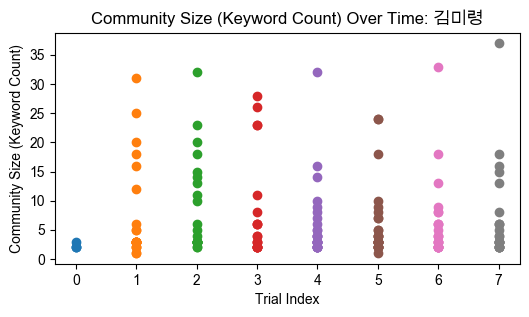

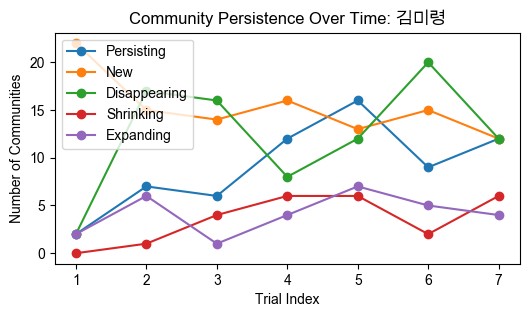


Persisting Communities:
('4.2. 요리/맛집',): 7
('4.3. 패션/뷰티',): 6
('7.4. 스타/연예인',): 5
('3.1. 사건사고',): 4
('4.8. 육아/교육',): 3

Disappearing Communities:
('8.4. 해외 축구',): 3
('2.5. 중소기업/창업',): 2
('1.1.2. 국회/입법부',): 2
('1.4.2. 무기/방위산업',): 2
('7.6. 셀러브리티/인플루언서',): 2

New Communities:
('4.10. 취미/DIY',): 3
('8.4. 해외 축구',): 3
('7.3. 음악',): 3
('4.11. 웨딩/결혼',): 3
('1.1.2. 국회/입법부',): 3

Shrinking Communities:
('4.2. 요리/맛집',): 3
('4.3. 패션/뷰티',): 2
('1.1.2. 국회/입법부',): 2
('2.2. 증권/주식',): 2
('7.4. 스타/연예인',): 2

Expanding Communities:
('4.2. 요리/맛집',): 4
('4.3. 패션/뷰티',): 3
('7.4. 스타/연예인',): 3
('2.6. 경제 정책',): 2
('4.8. 육아/교육',): 2
========== END: Analyzing 김미령 ==========
========== START: Analyzing 김태환 ==========


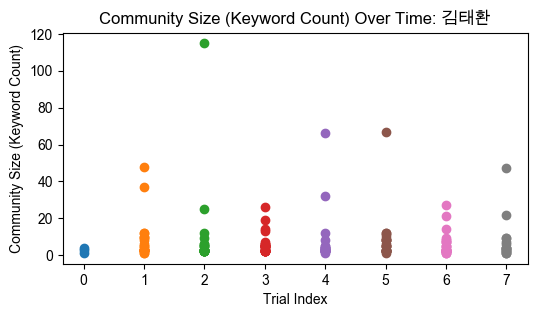

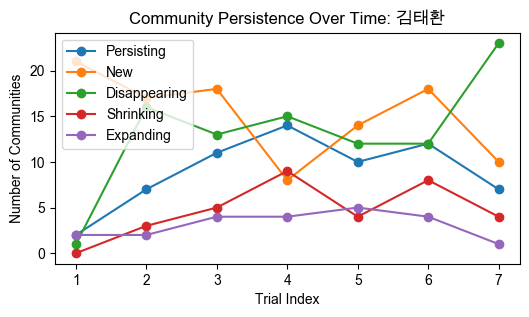


Persisting Communities:
('8.5. 골프',): 5
('4.2. 요리/맛집',): 5
('1.1.1. 청와대/행정부',): 5
('4.1. 건강',): 4
('4.5. 자동차',): 4

Disappearing Communities:
('8.4. 해외 축구',): 2
('3.1. 사건사고',): 2
('8.2. 해외 야구',): 2
('3.1.1. 국제 사건사고',): 2
('7.3. 음악',): 2

New Communities:
('8.2. 해외 야구',): 3
('7.3. 음악',): 3
('3.1. 사건사고',): 3
('5.6. 우주/항공',): 2
('3.5. 인권/복지',): 2

Shrinking Communities:
('2.2. 증권/주식',): 2
('4.2. 요리/맛집',): 2
('2.4. 산업/기업',): 2
('8.2. 해외 야구',): 2
('1.1.1. 청와대/행정부',): 2

Expanding Communities:
('8.5. 골프',): 3
('4.5. 자동차',): 2
('8.4. 해외 축구',): 2
('4.1. 건강',): 2
('1.1.1. 청와대/행정부',): 2
========== END: Analyzing 김태환 ==========
========== START: Analyzing 유효상 ==========


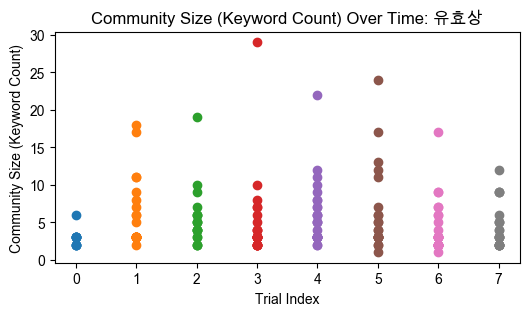

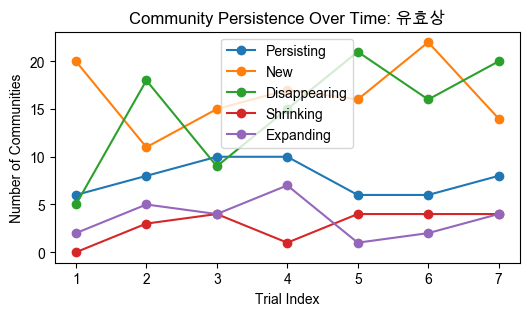


Persisting Communities:
('4.1. 건강',): 7
('3.2. 교육',): 5
('3.1. 사건사고',): 4
('4.4. 여행/레저',): 4
('8.2. 해외 야구',): 3

Disappearing Communities:
('2.3. 부동산',): 3
('12.1. 축제/페어',): 3
('2.6. 경제 정책',): 3
('11.1. 수도권',): 3
('4.10. 취미/DIY',): 2

New Communities:
('1.1.3. 지방자치',): 3
('3.3. 노동',): 3
('4.2. 요리/맛집',): 3
('7.2. 방송/드라마',): 3
('5.2. 인터넷/SNS',): 3

Shrinking Communities:
('3.1. 사건사고',): 3
('4.4. 여행/레저',): 2
('4.1. 건강',): 2
('3.2. 교육',): 2
('4.9. 반려동물',): 2

Expanding Communities:
('4.1. 건강',): 5
('4.5. 자동차',): 2
('3.2. 교육',): 2
('4.4. 여행/레저',): 2
('11.1. 수도권',): 1
========== END: Analyzing 유효상 ==========
========== START: Analyzing 이현지 ==========


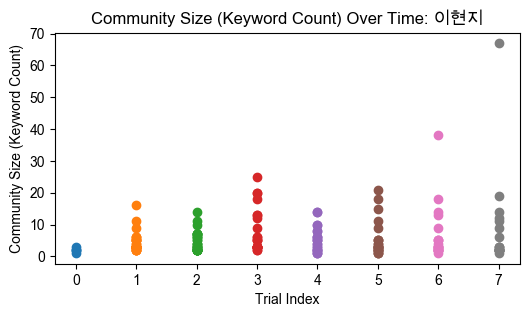

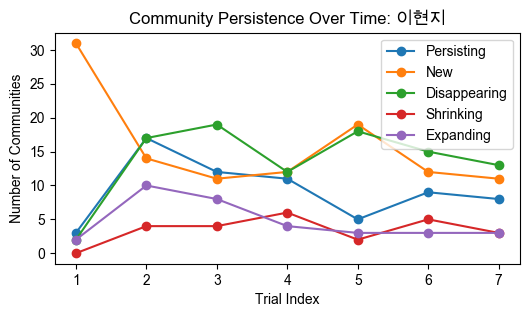


Persisting Communities:
('3.1. 사건사고',): 6
('4.1. 건강',): 5
('4.6. 책/문학',): 4
('3.2. 교육',): 4
('4.3. 패션/뷰티',): 4

Disappearing Communities:
('4.2. 요리/맛집',): 3
('8.4. 해외 축구',): 3
('12.2. 전시/공연',): 2
('4.4. 여행/레저',): 2
('1.1.2. 국회/입법부',): 2

New Communities:
('1.1.2. 국회/입법부',): 3
('5.1. 모바일',): 3
('8.4. 해외 축구',): 3
('8.3. 국내 축구',): 3
('1.1.1. 청와대/행정부',): 3

Shrinking Communities:
('7.4. 스타/연예인',): 2
('3.1. 사건사고',): 2
('3.2. 교육',): 2
('4.3. 패션/뷰티',): 2
('4.1. 건강',): 2

Expanding Communities:
('3.1. 사건사고',): 4
('4.6. 책/문학',): 3
('4.1. 건강',): 3
('4.5. 자동차',): 3
('1.1.3. 지방자치',): 2
========== END: Analyzing 이현지 ==========
========== START: Analyzing 정구선 ==========


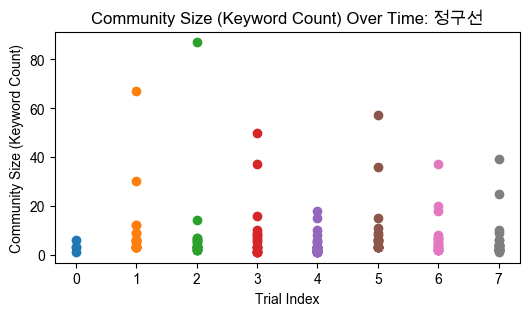

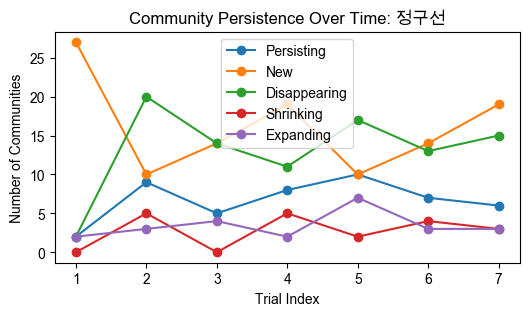


Persisting Communities:
('5.8. 블록체인/가상화폐',): 6
('4.4. 여행/레저',): 6
('8.2. 해외 야구',): 5
('8.5. 골프',): 4
('3.1. 사건사고',): 4

Disappearing Communities:
('4.5. 자동차',): 3
('11.1. 수도권',): 3
('5.1. 모바일',): 3
('2.1. 금융',): 3
('1.1.2. 국회/입법부',): 3

New Communities:
('4.1. 건강',): 3
('3.3. 노동',): 3
('11.1. 수도권',): 3
('7.3. 음악',): 3
('8.3. 국내 축구',): 3

Shrinking Communities:
('3.1. 사건사고',): 3
('8.2. 해외 야구',): 3
('4.4. 여행/레저',): 3
('5.8. 블록체인/가상화폐',): 2
('5.3. 통신/뉴미디어',): 1

Expanding Communities:
('5.8. 블록체인/가상화폐',): 4
('8.5. 골프',): 3
('4.4. 여행/레저',): 3
('7.4. 스타/연예인',): 2
('4.2. 요리/맛집',): 2
========== END: Analyzing 정구선 ==========
========== START: Analyzing 정주희 ==========


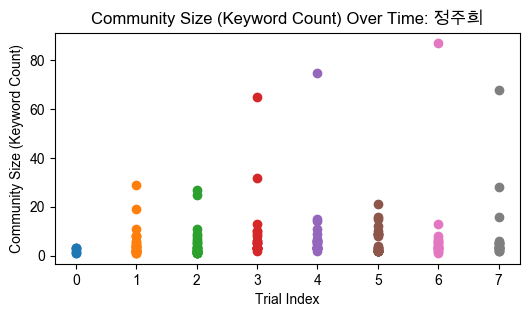

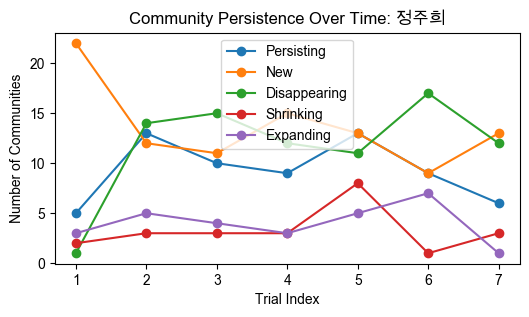


Persisting Communities:
('2.3. 부동산',): 6
('4.3. 패션/뷰티',): 6
('4.1. 건강',): 6
('4.4. 여행/레저',): 4
('4.2. 요리/맛집',): 4

Disappearing Communities:
('7.2. 방송/드라마',): 3
('3.2. 교육',): 3
('2.1. 금융',): 3
('12.1. 축제/페어',): 2
('7.4. 스타/연예인',): 2

New Communities:
('4.10. 취미/DIY',): 3
('3.2. 교육',): 3
('4.5. 자동차',): 3
('7.2. 방송/드라마',): 3
('2.1. 금융',): 3

Shrinking Communities:
('2.3. 부동산',): 4
('4.3. 패션/뷰티',): 3
('4.1. 건강',): 3
('12.1. 축제/페어',): 2
('4.10. 취미/DIY',): 2

Expanding Communities:
('4.4. 여행/레저',): 3
('3.1. 사건사고',): 3
('4.3. 패션/뷰티',): 3
('4.1. 건강',): 3
('3.3. 노동',): 2
========== END: Analyzing 정주희 ==========
========== START: Analyzing 최병건 ==========


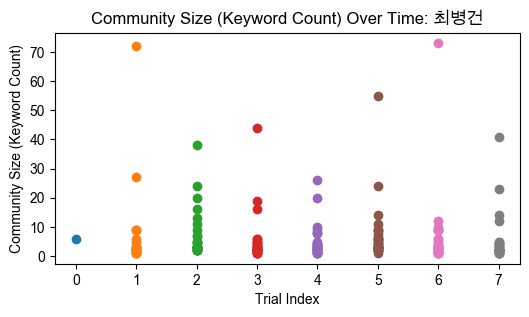

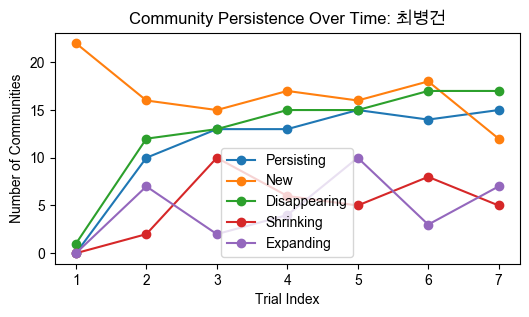


Persisting Communities:
('4.1. 건강',): 6
('2.3. 부동산',): 6
('7.2. 방송/드라마',): 5
('7.1. 영화',): 4
('5.8. 블록체인/가상화폐',): 4

Disappearing Communities:
('4.4. 여행/레저',): 3
('5.4. IT 기기',): 2
('1.4.3. 사이버 안보',): 2
('6.6. 세계 일반',): 2
('8.8. e스포츠',): 2

New Communities:
('4.4. 여행/레저',): 3
('7.4. 스타/연예인',): 2
('4.5. 자동차',): 2
('1.4.3. 사이버 안보',): 2
('6.6. 세계 일반',): 2

Shrinking Communities:
('2.3. 부동산',): 3
('7.1. 영화',): 2
('2.1. 금융',): 2
('5.5. 과학 일반',): 2
('4.1. 건강',): 2

Expanding Communities:
('4.1. 건강',): 4
('2.3. 부동산',): 3
('5.8. 블록체인/가상화폐',): 3
('5.7. 인공지능',): 2
('7.2. 방송/드라마',): 2
========== END: Analyzing 최병건 ==========
========== START: Analyzing 최지원 ==========


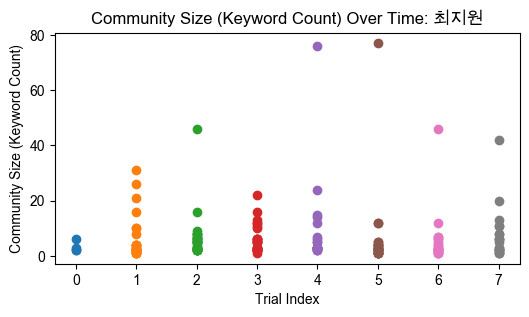

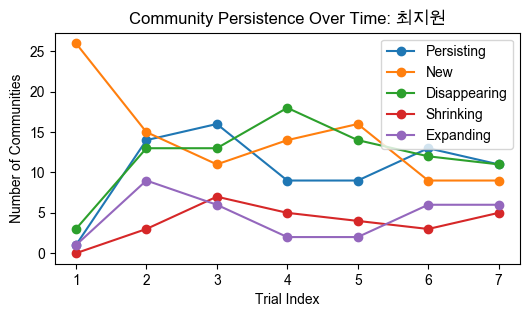


Persisting Communities:
('4.2. 요리/맛집',): 6
('2.3. 부동산',): 6
('4.1. 건강',): 6
('4.4. 여행/레저',): 6
('1.1.2. 국회/입법부',): 4

Disappearing Communities:
('5.6. 우주/항공',): 3
('7.4. 스타/연예인',): 2
('4.3. 패션/뷰티',): 2
('5.4. IT 기기',): 2
('12.1. 축제/페어',): 2

New Communities:
('8.4. 해외 축구',): 3
('5.6. 우주/항공',): 3
('2.6. 경제 정책',): 3
('7.2. 방송/드라마',): 3
('7.5. 애니메이션/웹툰',): 2

Shrinking Communities:
('4.1. 건강',): 4
('2.3. 부동산',): 4
('4.9. 반려동물',): 2
('1.1.2. 국회/입법부',): 2
('8.1. 국내 야구',): 2

Expanding Communities:
('4.2. 요리/맛집',): 4
('4.4. 여행/레저',): 4
('4.5. 자동차',): 3
('1.1.2. 국회/입법부',): 2
('4.9. 반려동물',): 2
========== END: Analyzing 최지원 ==========


In [7]:
unique_testers = df['tester'].unique()
for tester in unique_testers:
    print(f"========== START: Analyzing {tester} ==========")
    analyze_loop(df, tester)
    print(f"========== END: Analyzing {tester} ==========")
